# Group member:

CHANG Wen-Yu (01505913)

HONG YANG (01502068)

PHOO PYAE HSU MYAT (01520414)

ZHANG YINLIANG (01345913)

# [Content](#part1)
### [1. Implementation](#Implementation) 
### [2. Test cases with SmileAF ](#Results) 
### [3. Conclusion](#Conclusion) 
### [4. Improvements](#Improvements)



# Course Project: An Arbitrage-Free Smile Interpolator
*Project report should be submitted as a Jupyter notebook (.ipynb). Each project group should have 1 to 3 members. The report should be written based on this notebook. Please make your formulas and code, test results, observations, intermediate results, improvements made/suggested (optional), and conclusions clear.*

#### Objectives
  - Implement an arbitrage free smile interpolator SmileAF.
  - Use the arbitrage free smile interpolator to construct local volatility model
  - Use PDE with local volatility model to price a given set of European options (strike in delta $\times$ maturity)
  - Compare the price errors of arbitrage-free smile interpolator and the cubic spline smile interpolator
  - Open questions for bonus points: improve the algorithms in terms of precision and efficiency (smile interpolation, implied vol, local vol, PDE, calibration report). One area to consider for improvement is the construction of the tails (wings).

##### Smile Arbitrage
1. European call prices are monotonically decreasing with respect to the strike:

    \begin{align}
    C(S_0, K_1, T, \sigma(K_1), r, q) \geq C(S_0, K_2, T, \sigma(K_2), r, q) ~\text{for}~K_1 < K_2
    \end{align}


2. The European call price as a function of strike has to be convex every where: for any three points $K_1 < K_2 < K_3$

    \begin{align*}
    \frac{C(K_2) - C(K_1) } {K_2 - K_1} < \frac{C(K_3) - C(K_2) } {K_3 - K_2}
    \end{align*}

    or

    \begin{align}
    C(K_2)  < C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1}  \tag{2}
    \end{align}

    This is also equivalent to "butterfly price has to be non-negative".

##### When Could Smile Arbitrage Happen?

The undiscounted call price is the expectation of payoff under risk neutral measure

\begin{align*}
C(K) = E[\max(S-K, 0)]
\end{align*}

And expectation is an integral over the probability density function $p(s)$

\begin{align*}
C(K) = \int_{K}^{+\infty} (s-K) p(s) ds
\end{align*}

The 1st non-arbitrage condition translates to

\begin{align*}
& C(K_1) - C(K_2) = \left[ \int_{K_1}^{K_2} (s-K_1) p(s) ds  + \int_{K_2}^{+\infty} (K_2-K_1) p(s) ds \right]
\end{align*}

which is positive by definition if $K_2 > K_1$.

The 2nd non-arbitrage condition translates to

\begin{align*}
& C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1} - C(K_2) \\
= & \frac{K_3-K_2} {K_3 - K_1} \int_{K_1}^{K_2} (s-K_1) p(s) ds + \frac{K_2 - K_1} {K_3 - K_1} \int_{K_2}^{K_3} (K_3 - s) p(s) ds
\end{align*}

which is also positive by definition if $K_3 > K_2 > K_1$.

So, when could smile arbitrage happen? **When the probability density does not exist**. If we can start with valid probability density function $p(s)$, arbitrage-freeness is guaranteed by construction.


#### Arbitrage Free Smile (Based on [Fengler 2009])

- We consider smile construction for a given expiry $T$.
- Start with $N$ discrete sample strike points

    \begin{align*}
    \vec{k} = [k_1, k_2, \ldots, k_{N}]^{\top}
    \end{align*}

- Try to solve for undiscounted call prices for these $N$ sample points

    \begin{align*}
    \vec{c} = [c_1, c_2, \ldots, c_N]^{\top}
    \end{align*}

- For the undiscounted call price $C(K)$ for any $K$, we can interpolate using cubic spline over the sample points $(k_i, c_i)$. (Note that we are using cubic spline to interpolate the prices, not volatility)

- The second derivative of call price with respect to strike is the probability density function:

\begin{align*}
    \frac{d C}{d K} & =  d \frac{\int_K^{\infty} Sp(S) dS}{dK} - d \frac{K\int_K^{\infty} p(S) dS}{dK} = -Kp(K) - \left( \int_K^{\infty} p(S) dS - K p(K)\right) = -\int_K^{\infty} p(S) dS \\
    \frac{d^2 C}{d K^2} & = p(K)
\end{align*}

  So $c_i''$ is probability density function at $k_i$, we denote it as $p_i$

- Second derivatives in cubic spline interpolation form line segments. Cubic spline on $C(K)$, means linearly interpolate on probability density. If $p_i$ are all positive, the whole pdf is positive by construction --- **no smile arbitrage**.

- For tails --- call prices are almost linear if strike is very far away from spot, we can use **natural cubic spline**: $p_1 = p_N = 0$.

- Our problem is to solve for $[c_1, c_2, \ldots, c_{N}, p_2, \ldots, p_{N-1}]$

#### Inputs to our problem

Same as our Cubic Spline smile interpolator, we have the input marks to start with to construct the Arb-Free(AF) smile interpolator:

 - **Marks**:  strike to volatility pairs, denote as $(\hat k_j, \sigma_j)$, for $j \in [1, 2, \ldots, M]$. `In our case, $M=5$`.

We would like to match the marks exactly. And we cannot directly construct a cubic spline using the $M$ points --- too coarse and distribution is not realistic.

#### Problem Definition
- `We use $N = 50$ sample points` , ranging from $[k_1 = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T - 5 \sigma_{ATM} \sqrt{T}}, k_N = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T + 5 \sigma_{ATM} \sqrt{T} }]$, i.e., $\pm 5$ standard deviation based on $\sigma_{ATM}$.
- $\sigma_{ATM}$ is implied volatility of the middle point of the input marks.
- We also assume the strike of the middle point of the input marks is the forward --- ATM forward convention.
- The sample points are equally spaced, denote the length of the segment $u = \frac{k_N - k_1}{N-1}$
- We would like the call prices to be as smooth as possible --- minimize the change of the slopes
- We want to match exactly the $M$ input marks.
- This is a constrained optimization problem.

 **Constraints**
 - Cubic spline interpolation imposes the constraints that the left and right first derivative of a point have to match, it can be derived by matching the first  derivative of the left and right segments for point $i$ we have the condition

\begin{align*}
   c_{i+1} + c_{i-1} - 2 c_{i} = (\frac23 p_i + \frac16 p_{i+1} + \frac16 p_{i-1}) u^2
\end{align*}

   The cubic spline constraints translate to the linear system

\begin{align*} 
\underbrace{\begin{pmatrix}
   1 & -2 & 1 & 0 & \ldots & 0 \\
   0 & 1 & -2 & 1 & \ddots & \vdots \\
   \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
   0 & \ldots & 0 & 1 & -2 & 1
   \end{pmatrix}}_{\vec{Q}_{(N-2) \times N}}
   \begin{pmatrix}
   c_1 \\
   c_2 \\
   \vdots \\
   c_N
   \end{pmatrix} =
   \underbrace{u^2
   \begin{pmatrix}
   \frac23 & \frac16 & 0 & \ldots & 0 \\
   \frac16 & \frac23 & \frac16 & \ddots & \vdots \\
   0 & \ddots & \ddots & \ddots & 0 \\
   \vdots & \ddots & \frac 1 6 & \frac23 & \frac16 \\
   0 & \ldots & 0 & \frac 1 6 &  \frac23
   \end{pmatrix}}_{\vec{R}_{(N-2) \times (N-2)}}
   \begin{pmatrix}
   p_2 \\
   p_3 \\
   \vdots \\
   p_{N-1}
   \end{pmatrix}
\end{align*}

   If we define
\begin{align*}
   \vec{x} =
   \begin{pmatrix}
   \vec{c}^{\top} \\
   \vec{p}^{\top} \\
   \end{pmatrix}, ~~~
   \vec{A} = (\vec{Q}, -\vec{R})
\end{align*}

   we can represent the constraint as:
\begin{align*}
   \vec{Ax} = \vec{0}        ~~~\textbf{--- Constraint 1}
\end{align*}

 - The call prices at the input marks $\hat k_j, j \in [1, 2, \ldots, M]$ can be represented by cubic spline interpolation
\begin{align*}
   C(\hat k_j) =  a c_i + b c_{i+1} + \frac{(a^3 - a)u^2}6 p_i + \frac{(b^3-b) u^2}6 p_{i+1}   ~~~\textbf{--- Constraint 2}
\end{align*}

   where

\begin{align*}
   a = \frac{k_{i+1} - \hat k_j}{u},~~~b = 1-a
\end{align*}

   and $[k_i, k_{i+1}]$ here represents the segment that $\hat k_j$ falls in.

 - $p_i$ are densities, so

\begin{align*}
    p_i > 0 ~~~\textbf{--- Constraint 3}
\end{align*}

 - Integrating the density function we should get 1.0 (recall that density function are linearly interpolated)

\begin{align*}
    u \sum p_i = 1.0 ~~~\textbf{--- Constraint 4}
\end{align*}

 - Natural cubic spline, $p_1$ and $p_N$ are zero, so we could solve directly $c_1$ and $c_N$

    \begin{align*}
    c_1 = Se^{(r_d - r_f)T} - k_1, ~~~c_N = 0  ~~~\textbf{--- Constraint 5}
    \end{align*}

 - Call prices are monotonically decreasing:

    \begin{align*}
    c_{i+1} - c_{i} \leq 0 ~~~\text{for}~i \in \{1, 2, \ldots, N-1\}  ~~~\textbf{--- Constraint 6}
    \end{align*}

---
#### Adding a Penalty Term for Smoother Densities

- In order to discourage large jumps in the risk-neutral density between adjacent grid points, we add a penalty term on the differences $$p_{i+1} - p_i$$ 
Concretely, we define:

$$
\text{penalty} \;=\; \lambda \sum_{i=2}^{N-2} \bigl(p_{i+1} - p_i\bigr)^2 \textbf{--- Constraint 7.1}
$$

- Here, `lambda` is a small positive constant that controls how heavily we penalize the density’s “roughness.”  
This penalty is added directly to the **objective function** of our quadratic program.

- We do this by modifying the Hessian matrix `H`, adding `lambda * M` into the bottom-right block of `H`,  
where `M` is the matrix representation of the discrete difference operator.


##### Why This Helps

- **Reduced Oscillations**:  
  The solver will prefer solutions where `p` varies more smoothly across strikes.

- **Maintaining Fit**:  
  By keeping `lambda` small, we still fit the market quotes accurately  
  while avoiding wild swings in the implied PDF.


- As a result, the solution `(c_i, p_i)` becomes smoother and more stable, while still respecting all arbitrage-free pricing constraints.

---
####  Tail Constraints (Extrapolation)

- In the QP formulation, we add **equality constraints** to control behavior at the tails of the strike grid:

#####  Left Tail Constraint (Deep ITM)
- We enforce a linear slope for the call price:
$$
\frac{C(k_2) - C(k_1)}{k_2 - k_1} = \text{slope}  \textbf{--- Constraint 7.2}
$$
- For example, using slope= -1, the constraint becomes:
$$
C(k_2) - C(k_1) = (k_2 - k_1)(-1)
$$

- This avoids erratic curvature in the deep in-the-money region and keeps the call price smooth and decreasing.

#####  Right Tail Constraint (Far OTM)
- We assume the call price flattens or vanishes for high strikes. A common constraint is:
$$
C(k_N) - C(k_{N-1}) = 0 \textbf{--- Constraint7.3}
$$
- This sets the call price to be **flat** or **asymptotically zero** at high strikes, which is consistent with no-arbitrage for far OTM options.

- These constraints are included **inside the QP** (not post-processed), preserving convexity and smoothness across the entire domain.

---

 **Objective Function**

 - Fill the rest of the DOF using objective function (soft constraints)

 - [Fengler 2009] tried minimizing the below to achieve smoothness on $p$:

    \begin{align*}
    \int_{k_1}^{k_N} p(S)^2 dS = \text{constant} \times \vec{p}^{\top} \vec{R} \vec{p}
    \end{align*}

    Using $\vec{x}$ as variable and define

    \begin{align*}
    \vec{H}_{(2N-2) \times (2N-2)} =
    \begin{pmatrix}
    \vec{0} & \vec{0} \\
    \vec{0} & \vec{R}_{(N-2) \times (N-2)}
    \end{pmatrix}
    \end{align*}

    the problem becomes minimizing

    \begin{align*}
    \vec{x}^\top \vec{H} \vec{x}
    \end{align*}

**Problem Formulation**

We can formulate our problem as
\begin{align*}
    \min~~~\vec{x}^\top \vec{H} \vec{x}
\end{align*}
 `subject to constraints 1 to 5`.
 - All the constraints are linear function of $\vec{x}$
 - Our objective function is quadratic and the matrix $\vec{H}$ is positive semi-definite
 - Global solution exists, and (relatively) efficient to solve

**Tips**
 - To solve the quadratic programming problem, we can use the CVXOPT package:
   - http://cvxopt.org/examples/tutorial/qp.html
   - https://buildmedia.readthedocs.org/media/pdf/cvxopt/dev/cvxopt.pdf
 - Write down the exact formulas using the same symbols used by CVXOPT QP problem's documentation in the above docs, then translate them into code. This will make debugging easier.
 - To check whether solver's result makes sense, examine if the constraints are satisified, and if the call prices are smooth and match the input.
 - If test run takes too long, reduce the number of grid points in PDE pricer, or skip the calibration report and inspect the volatility surface first.
 - It might be easier to plot implied vol, call prices, PDF, and the marks to check the result.
 - use bisect.bisect_left to find the bucket $\hat{k}$ belongs to (https://docs.python.org/3/library/bisect.html)

**References**

[Fengler 2009] Arbitrage-free smoothing of the implied volatility surface, Quantitative Finance, 2009

***
### Implementation

In [1]:
import math
from enum import Enum
from scipy import optimize
import bisect
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from cvxopt import matrix, solvers
import concurrent.futures
from scipy.linalg import solve_banded
from functools import lru_cache

In [2]:
# ------------------------------
# Basic Functions and Utilities
# ------------------------------

class PayoffType(Enum):
    Call = 0
    Put = 1

def cnorm(x):
    """
    Standard normal cumulative distribution function.
    
    Parameters:
        x (float): Input value.
    
    Returns:
        float: CDF evaluated at x.
    """
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def fwdDelta(fwd, stdev, strike, payoffType):
    """
    Computes the forward delta for a given option.
    
    Parameters:
        fwd (float): Forward price.
        stdev (float): Standard deviation.
        strike (float): Strike price.
        payoffType (PayoffType): Option type (Call or Put).
    
    Returns:
        float: Delta value.
    """
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return -cnorm(-d1)
    else:
        raise Exception("Unsupported payoff type", payoffType)

def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    """
    Finds the strike such that the option delta equals the given delta.
    
    Parameters:
        S (float): Spot price.
        r (float): Risk-free rate.
        q (float): Dividend yield.
        T (float): Time to maturity.
        vol (float): Volatility.
        delta (float): Target delta.
        payoffType (PayoffType): Option type (Call or Put).
    
    Returns:
        float: Strike corresponding to the target delta.
    """
    fwd = S * math.exp((r - q) * T)
    if payoffType == PayoffType.Put:
        delta = -delta
    func = lambda K: fwdDelta(fwd, vol * math.sqrt(T), K, payoffType) - delta
    return optimize.brentq(func, 0.0001, 10000)

In [3]:
# ------------------------------
# Enumerations and Option Classes
# ------------------------------

class EuropeanOption:
    """
    European Option for pricing.
    """
    def __init__(self, assetName, expiry, strike, payoffType):
        """
        Initializes the option.
        
        Parameters:
            assetName (str): Name of the underlying asset.
            expiry (float): Time to expiry.
            strike (float): Strike price.
            payoffType (PayoffType): Call or Put.
        """
        self.assetName = assetName
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType

    def payoff(self, S):
        """
        Computes the payoff for a given spot price S.
        
        Parameters:
            S (float): Spot price.
        
        Returns:
            float: Option payoff.
        """
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("Unsupported payoff type", self.payoffType)

    def valueAtNode(self, t, S, continuation):
        """
        Returns the node value (for PDE solvers).
        
        Parameters:
            t (float): Time.
            S (float): Spot price.
            continuation (float or None): Continuation value.
        
        Returns:
            float: Node value.
        """
        return self.payoff(S) if continuation is None else continuation


### Refine the function:
**Caching:**
- We use an LRU cache (@lru_cache) for the volatility interpolation through a dedicated method `Vol_cached`. This means that if you call the volatility function repeatedly with the same parameters (which happens a lot when computing numerical derivatives), you avoid recalculating the value. The old version recalculates everything every time you call `Vol`, making it potentially slower in performance-critical applications.

**Consistency in Derivative Methods:**  
- It leverages the caching in its numerical derivative functions (`dVoldK`, `dVoldT`, `dVol2dK2`) to ensure that repeated volatility evaluations are optimized. In contrast, the old version computes these values directly without caching, which might result in redundant and expensive calculations.


In [4]:
# ------------------------------
# Implied and Local Volatility Classes
# ------------------------------

class ImpliedVol:
    """
    Represents the implied volatility surface via discrete smiles.
    """
    def __init__(self, ts, smiles):
        """
        Parameters:
            ts (list): List of maturities.
            smiles (list): List of smile objects corresponding to each maturity.
        """
        self.ts = ts
        self.smiles = smiles

    def Vol(self, t, k):
        """
        Interpolates implied volatility at time t and strike k.
        
        Parameters:
            t (float): Time to maturity.
            k (float): Strike price.
        
        Returns:
            float: Implied volatility.
        """
        
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1 - w) * nextVar) / t)

    @lru_cache(maxsize=None)
    def Vol_cached(self, t, k):
        """
        Cached version of Vol.
        """
        return self.Vol(t, k)

    def dVoldK(self, t, k, dk=0.001):
        """
        Approximates the derivative of volatility with respect to strike.
        
        Parameters:
            t (float): Time to maturity.
            k (float): Strike.
            dk (float): Step size.
        
        Returns:
            float: dVol/dK.
        """
        vol_minus = self.Vol_cached(t, k - dk)
        vol_plus = self.Vol_cached(t, k + dk)
        return (vol_plus - vol_minus) / (2 * dk)

    def dVoldT(self, t, k, dt=0.005):
        """
        Approximates the derivative of volatility with respect to time.
        
        Parameters:
            t (float): Time to maturity.
            k (float): Strike.
            dt (float): Time step.
        
        Returns:
            float: dVol/dT.
        """
        return (self.Vol_cached(t + dt, k) - self.Vol_cached(t, k)) / dt

    def dVol2dK2(self, t, k, dk=0.001):
        """
        Approximates the second derivative of volatility with respect to strike.
        
        Parameters:
            t (float): Time to maturity.
            k (float): Strike.
            dk (float): Strike step.
        
        Returns:
            float: d²Vol/dK².
        """
        vol_minus = self.Vol_cached(t, k - dk)
        vol_center = self.Vol_cached(t, k)
        vol_plus = self.Vol_cached(t, k + dk)
        return (vol_plus + vol_minus - 2 * vol_center) / (dk ** 2)

class LocalVol:
    """
    Computes the local volatility using Dupire's formula.
    """
    def __init__(self, iv, S0, rd, rf):
        """
        Parameters:
            iv (ImpliedVol): Implied volatility surface.
            S0 (float): Current spot.
            rd (float): Domestic rate.
            rf (float): Foreign rate.
        """
        self.iv = iv
        self.S0 = S0
        self.rd = rd
        self.rf = rf

    def LV(self, t, s):
        """
        Computes the local volatility at time t and spot s.
        
        Parameters:
            t (float): Time.
            s (float): Spot.
        
        Returns:
            float: Local volatility.
        """
        if t < 1e-6:
            return self.iv.Vol_cached(t, s)
        imp = self.iv.Vol_cached(t, s)
        dvdk = self.iv.dVoldK(t, s)
        dvdt = self.iv.dVoldT(t, s)
        d2vdk2 = self.iv.dVol2dK2(t, s)
        d1 = (math.log(self.S0 / s) + (self.rd - self.rf) * t + imp * imp * t / 2) / (imp * math.sqrt(t))
        numerator = imp * imp + 2 * t * imp * dvdt + 2 * (self.rd - self.rf) * s * t * imp * dvdk
        denominator = (1 + s * d1 * math.sqrt(t) * dvdk) ** 2 + s * s * t * imp * (d2vdk2 - d1 * math.sqrt(t) * dvdk * dvdk)
        localvar = min(max(numerator / denominator, 1e-8), 1.0)
        if numerator < 0:
            localvar = 1e-8
        if denominator < 0:
            localvar = 1.0
        return math.sqrt(localvar)


### Refine the function:
**pdePricerX:**
- The first version of `pdePricerX` uses a basic approach, constructing the full matrix at each time step through nested loops and solving the system via explicit matrix inversion. While functionally correct, this method is both computationally expensive and memory-intensive, making it unsuitable for large-scale problems.

- Then we try to make it cost less computationally by vectorizing the grid and coefficient construction. It replaces the matrix inversion with `np.linalg.solve`, which enhances numerical stability and reduces computational cost. However, it still assembles the full matrix, so memory usage remains relatively high.

- The last version offers the most efficient implementation. It exploits the tridiagonal nature of the PDE system by constructing only the three necessary diagonals and solving the system with SciPy’s `solve_banded`. This eliminates the need for full matrix storage, significantly reduces time complexity, and applies boundary conditions directly in the right-hand side vector. As a result, this version achieves superior performance, memory efficiency, and scalability, making it the preferred approach for production-level applications.

In [5]:
# ------------------------------
# Pricing Functions
# ------------------------------

def bsPrice(S, r, q, vol, T, strike, payoffType):
    """
    Black-Scholes analytic pricer.
    
    Parameters:
        S (float): Spot price.
        r (float): Risk-free rate.
        q (float): Dividend yield.
        vol (float): Volatility.
        T (float): Time to maturity.
        strike (float): Strike price.
        payoffType (PayoffType): Call or Put.
    
    Returns:
        float: Option price.
    """
    fwd = S * math.exp((r - q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - strike * cnorm(d2))
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - fwd * cnorm(-d1))
    else:
        raise Exception("Unsupported payoff type", payoffType)
    
def pdePricerX(S0, r, q, lv, NX, NT, w, trade):
    """
    PDE pricer using local volatility.

    Parameters:
        S0 (float): Spot price.
        r (float): Risk-free rate.
        q (float): Dividend yield.
        lv (LocalVol): Local volatility object.
        NX (int): Number of spatial grid points.
        NT (int): Number of time grid points.
        w (float): Theta parameter (weight).
        trade (EuropeanOption): Option to be priced.

    Returns:
        float: Option price computed by PDE.
    """
    # Set up pde grid parameters
    mu = r - q
    T = trade.expiry
    X0 = math.log(S0)
    vol0 = lv.LV(0, S0)
    srange = 5 * vol0 * math.sqrt(T)
    maxX = X0 + (mu - 0.5 * vol0**2) * T + srange
    minX = X0 - (mu - 0.5 * vol0**2) * T - srange
    dt = T / (NT - 1)          # time step size
    dx = (maxX - minX) / (NX - 1)  # spatial step size

    # Create spatial grid and corresponding spot prices.
    xGrid = np.linspace(minX, maxX, NX)
    S_grid = np.exp(xGrid)
    
    # Set initial condition: option payoff at expiry.
    ps = np.array([trade.payoff(s) for s in S_grid])
    
    # Time stepping loop (backwards in time)
    for j in range(1, NT):
        t = j * dt
        # Compute interior indices (excluding boundaries)
        indices = np.arange(1, NX - 1)
        s_interior = S_grid[indices]
        # Evaluate local volatility at interior nodes
        vol_arr = np.array([lv.LV(t, s) for s in s_interior])
        term1 = vol_arr**2
        # Compute finite difference coefficients for spatial derivatives:
        # 'lower' corresponds to the coefficient of ps[i-1]
        lower = (mu - 0.5 * term1) / (2.0 * dx) - term1 / (2.0 * dx**2)
        # 'diag' corresponds to the coefficient of ps[i]
        diag  = r + term1 / (dx**2)
        # 'upper' corresponds to the coefficient of ps[i+1]
        upper = -(mu - 0.5 * term1) / (2.0 * dx) - term1 / (2.0 * dx**2)
        
        # Build bands for the left-hand side matrix:
        main_diag = np.ones(NX)
        sub_diag = np.zeros(NX - 1)
        sup_diag = np.zeros(NX - 1)
        # For interior nodes, adjust main diagonal using the implicit (1-w) factor
        main_diag[1:-1] += (1 - w) * dt * diag
        sub_diag[:NX - 2] = (1 - w) * dt * lower
        sup_diag[1:] = (1 - w) * dt * upper
        # Assemble banded matrix with three diagonals:
        # Row 0: upper diagonal, Row 1: main diagonal, Row 2: lower diagonal.
        ab = np.zeros((3, NX))
        ab[0, 1:] = sup_diag
        ab[1, :]  = main_diag
        ab[2, :-1] = sub_diag
        
        # Build the right-hand side vector b:
        # For interior nodes, subtract the explicit (w dt * M) term from previous step values.
        b = np.empty(NX)
        b[1:-1] = ps[1:-1] - w * dt * (lower * ps[:-2] + diag * ps[1:-1] + upper * ps[2:])
        # For boundaries, impose discounted payoff values.
        b[0] = dt * math.exp(-r * t) * trade.payoff(S_grid[0])
        b[-1] = dt * math.exp(-r * t) * trade.payoff(S_grid[-1])
        
        # Solve the banded system for this time step.
        ps = solve_banded((1, 1), ab, b)
    
    # Interpolate the solution at the initial log-price X0.
    return np.interp(X0, xGrid, ps)

def DiagonalMatrix(a, b, c, d, nrow, ncol):
    """
    Builds a banded diagonal matrix for QP constraints.
    
    Parameters:
        a, b, c, d (float): Diagonal elements.
        nrow (int): Number of rows.
        ncol (int): Number of columns.
    
    Returns:
        cvxopt.matrix: Constructed matrix.
    """
    A = np.zeros((nrow, ncol))
    np.fill_diagonal(A[1:], a)
    np.fill_diagonal(A, b)
    np.fill_diagonal(A[:, 1:], c)
    np.fill_diagonal(A[:, 2:], d)
    return matrix(A)

def ZeroMatrix(nrow, ncol):
    """
    Creates a zero matrix.
    
    Parameters:
        nrow (int): Number of rows.
        ncol (int): Number of columns.
    
    Returns:
        cvxopt.matrix: Zero matrix.
    """
    return matrix(np.zeros((nrow, ncol)))

Below are the smile interpolators and smile constructor. You need to implement SmileAF. Note that smileFromMarks takes a parameter smileInterpMethod. When it is 'AF', SmileAF is used.

### Building Smile AF Constraints:

#### Constraints 7 in SmileAF
- Constraint 7.1 (Penalty on Density Smoothness):
    - It adds a regularization (via a discrete Laplacian penalty) to ensure that the density derived from the call prices is smooth. This is crucial because a rough density can lead to numerical instabilities and erratic implied vol behavior.
- Constraint 7.2 (Left Tail Slope):
    - This constraint enforces a specific slope for the left tail of the call price curve. It helps control the behavior of the surface at low strikes, reducing the risk of arbitrage by making sure the curve doesn’t get too steep.
- Constraint 7.3 (Right Tail Slope):
    - It forces the call price curve to flatten (i.e., zero slope) on the right tail. This helps in taming the behavior at high strikes, ensuring that the density (and hence the implied volatility) doesn’t behave wildly in the wings.
- We add extra terms into the Hessian’s c–block (the first self.N × self.N part) that penalize deviations from the desired tail slopes. (For the left tail, we want a slope of –1; for the right tail, a slope of 0.) These extra penalties are “soft”.

In [6]:
# ------------------------------
# Smile Interpolation Classes
# ------------------------------

class SmileCubicSpline:
    """
    Smile interpolation using Cubic Spline.
    """
    def __init__(self, strikes, vols):
        """
        Parameters:
            strikes (list): List of strikes.
            vols (list): List of volatilities.
        """
        self.strikes = strikes + [1.1 * strikes[-1] - 0.1 * strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1] - vols[-2]) / 10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        """
        Interpolates volatility for a given strike.
        
        Parameters:
            k (float): Strike.
        
        Returns:
            float: Interpolated volatility.
        """
        if k < self.strikes[0]:
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        return self.cs(k)

class SmileAF:
    """
    Smile interpolation using the AF method via QP.
    """
    def __init__(self, strikes, vols, T):
        """
        Parameters:
            strikes (list): List of strikes.
            vols (list): List of volatilities.
            T (float): Time to maturity.
        """
        self.atmvol = vols[int(len(vols) / 2)]
        self.fwd = strikes[int(len(strikes) / 2)]
        self.T = T
        self.N = 50
        stdev = self.atmvol * math.sqrt(T)
        kmin = self.fwd * math.exp(-0.5 * stdev * stdev - 5 * stdev)
        kmax = self.fwd * math.exp(-0.5 * stdev * stdev + 5 * stdev)
        u = (kmax - kmin) / (self.N - 1)
        self.ks = [kmin + u * i for i in range(self.N)]
        self.cs = np.zeros(self.N)  # undiscounted call option prices
        self.ps = np.zeros(self.N)  # densities
        self.u = u
        # now we need to construct our constrained optimization problem to solve for cs and ps
        # ... YOUR CODE HERE ... to solve for self.cs and self.ps

        # Constraint 1: Cubic spline smoothness for prices and densities.
        Q = DiagonalMatrix(0, 1, -2, 1, self.N - 2, self.N) # Constraint 1 Q matrix
        R = DiagonalMatrix(1/6, 2/3, 1/6, 0, self.N - 2, self.N - 2) # Constraint 1 R matrix
        H_np = np.zeros((2 * self.N - 2, 2 * self.N - 2)) # H matrix
        H_np[self.N:, self.N:] = np.array(R) # R： (N-2) x (N-2)
        H = matrix(H_np) # cvxopt.matrix

        A_Constraint1 = matrix([[Q], [-self.u**2 * R]]) # Combine Q and -u^2 * R into constraint matrix A
        ZeroVec_Constraint1 = ZeroMatrix(self.N - 2, 1) # Right-hand side of constraint 1, set to zero

        # Constraint 2: Matching the input marks.
        A_Constraint2 = matrix([[ZeroMatrix(len(strikes), self.N)],
                                [ZeroMatrix(len(strikes), self.N - 2)]]) # Initialize for c & p coefficients
        b_Constraint2 = matrix([ZeroMatrix(len(strikes), 1)])
        for i, kj in enumerate(strikes):
            position = bisect.bisect_left(self.ks, kj)  # Find the position of kj in the sample strikes
            a = (self.ks[position] - kj) / self.u  # Coefficient a for linear interpolation of c
            b = 1 - a  # Coefficient b for linear interpolation of c
            c = (a * a * a - a) * self.u * self.u / 6.0  # Coefficient c for cubic term of p
            d = (b * b * b - b) * self.u * self.u / 6.0  # Corrected coefficient d for cubic term of p
            A_Constraint2[i, position - 1] = a  # Assign a to c_{i-1}
            A_Constraint2[i, position] = b  # Assign b to c_i
            A_Constraint2[i, self.N + position - 2] = c  # Assign c to p_{i-1}
            A_Constraint2[i, self.N + position - 1] = d  # Assign d to p_i
            prc = bsPrice(self.fwd, 0, 0, vols[i], self.T, kj, PayoffType.Call)  # Calculate undiscounted BS price at kj
            b_Constraint2[i, 0] = prc 

        # Constraint 3: positive of the density
        G_Constraint3 = matrix(-np.eye(self.N - 2)) # Negative identity matrix for p_2 to p_{N-1}

        # Constraint 4: density integrates to 1
        A_Constraint4 = matrix([[ZeroMatrix(1, self.N)], # No contribution from c coefficients
                                [matrix(self.u * np.ones((1, self.N - 2)))]]) # u times a vector of ones for p_2 to p_{N-1}
        b_Constraint4 = matrix([1.0]) # set to 1

        # Constraint 5: boundary condition: c_1 = F - k_1, c_N = 0
        BoundaryMatrix = ZeroMatrix(2, 2 * self.N - 2)  # Size: 2 x (N + N-2)
        BoundaryMatrix[0, 0] = 1  # Set c_1 coefficient to 1
        BoundaryMatrix[1, self.N - 1] = 1  # Set c_N coefficient to 1
        
        A_Constraint5 = matrix([BoundaryMatrix]) # constraint matrix for boundary conditions
        
        BoundaryValues = ZeroMatrix(2, 1)
        BoundaryValues[0, 0] = self.fwd - self.ks[0]  # c_1 = F - k_1
        b_Constraint5 = matrix([BoundaryValues])

        # Constraint 6: monotonicity
        G_Constraint6 = DiagonalMatrix(0, -1, 1, 0, self.N - 1, self.N)  # Tridiagonal matrix for c coefficients

        G = matrix([[G_Constraint6, ZeroMatrix(self.N - 2, self.N)],
            [ZeroMatrix(self.N - 1, self.N-2), G_Constraint3]])
        h_inequality = ZeroMatrix(2 * self.N - 3, 1)    #right-hand side vector h for inequality constraints G * x <= h

        # Constraint 7: penalty + tail slope control
        def buildPenaltyMatrix(n_p):
            """
            Build the discrete Laplacian penalty matrix for the p-variables.
            This corresponds to sum_{i=1}^{n_p-1} (p_{i+1} - p_i)^2.
            """
            M = np.zeros((n_p, n_p))
            for i in range(n_p):
                M[i, i] = 2.0
                if i < n_p - 1:
                    M[i, i+1] = -1.0
                    M[i+1, i] = -1.0
            return M

        # Penalty parameters
        lambda_ = 1e-3       # penalty for density smoothing (for p-variables)
        lambda_tail = 1e-2   # penalty for tail slope deviation (for c-variables)

        # Number of p-variables is (N - 2)
        n_p = self.N - 2
        # Build the smoothing penalty matrix for densities
        M_np = buildPenaltyMatrix(n_p)
        # Add the density smoothing penalty to the bottom-right block of H_np
        H_np[self.N:, self.N:] += lambda_ * M_np

        # --- Add soft tail slope penalties into the c-block (upper-left self.N x self.N part) ---

        # For the left tail: we desire a slope of -1, i.e., (c_2 - c_1) should equal -self.u.
        # A quadratic penalty on (c_2 - c_1 + self.u)^2 has the Hessian contribution: lambda_tail * [[1, -1], [-1, 1]]
        H_np[0:2, 0:2] += lambda_tail * np.array([[1, -1], [-1, 1]])

        # For the right tail: we desire a slope of 0, i.e., (c_N - c_{N-1}) should equal 0.
        # The penalty (c_N - c_{N-1} - 0)^2 contributes lambda_tail * [[1, -1], [-1, 1]]
        H_np[self.N-2:self.N, self.N-2:self.N] += lambda_tail * np.array([[1, -1], [-1, 1]])

        # Now convert H_np into a CVXOPT matrix
        H = matrix(H_np)

        # Final: Problem Formulation - Solve minxHx (To solve the quadratic programming problem, we can use the CVXOPT package:)
        # Combine all equality constraints into A and b for the QP solver
        A = matrix([A_Constraint1, A_Constraint2, A_Constraint4, A_Constraint5])
        b = matrix([ZeroVec_Constraint1, b_Constraint2, b_Constraint4, b_Constraint5])
        P = 2 * H  # P corresponds to the matrix P in the QP problem: min 1/2 x^T P x, where P = 2 * H
        q = matrix(np.zeros(2 * self.N - 2))  # linear term (all zeros)
        sol = solvers.qp(P, q, G, h_inequality, A, b) # Solve the QP problem
        res = np.array(sol["x"]).flatten() # Flatten output to 1D array [c_1, ..., c_N, p_2, ..., p_{N-1}]
        self.cs = res[      :self.N] # undiscounted call prices (c_i)
        self.ps[1:-1] = res[self.N: ] # densities p_2 to p_{N-1} (p_1 = p_N = 0)

        # now we obtained cs and ps, we do not interpolate for price for any k and imply the vol,
        # since at the tails the price to vol gradient is too low and is numerically not stable.
        # Instead, we imply the volatilities for all points between put 10 delta and call 10 delta input points
        # then we make the vol flat at the wings by setting the vols at kmin and kmax,
        # we then construct a cubic spline interpolator on the dense set of volatilities so that it's C2
        # and faster then implying volatilities on the fly.
        # note that this treatment of tail is simplified. It could also introduce arbitrage.
        # In practice, the tails should be calibrated to a certain distribution.

        # Tail treatment for the implied vols
        def implyVol(k, prc, v):
            stdev = v * math.sqrt(self.T)
            d1 = (math.log(self.fwd / k)) / stdev + 0.5 * stdev
            d2 = d1 - stdev
            return self.fwd * cnorm(d1) - k * cnorm(d2) - prc
        khmin = bisect.bisect_left(self.ks, strikes[0])
        khmax = bisect.bisect_right(self.ks, strikes[len(strikes) - 1])
        kks = [0] * ((khmax + 1) - (khmin - 1) + 2)
        vs = [0] * ((khmax + 1) - (khmin - 1) + 2)
        for i in range(khmin - 1, khmax + 1):
            prc = self.Price(self.ks[i])
            f = lambda v: implyVol(self.ks[i], prc, v)
            a, b_val = 1e-8, 10
            vs[i - (khmin - 1) + 1] = optimize.brentq(f, a, b_val)
            kks[i - (khmin - 1) + 1] = self.ks[i]
        kks[0] = kmin
        vs[0] = vs[1]
        kks[-1] = kmax
        vs[-1] = vs[-2]
        self.vs = vs
        self.cubicVol = CubicSpline(kks, vs, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        """
        Interpolates the smile volatility for a given strike.
        
        Parameters:
            k (float): Strike.
        
        Returns:
            float: Volatility.
        """
        if k < self.ks[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vs[0]
        if k > self.ks[-1]:
            return self.vs[-1]
        else:
            return self.cubicVol(k)

    # undiscounted call price - given cs and ps,
    # we can obtain undiscounted call price for any k via cubic spline interpolation
    def Price(self, k):
        """
        Computes the option price based on the interpolated smile.
        
        Parameters:
            k (float): Strike.
        
        Returns:
            float: Option price.
        """
        if k <= self.ks[0]:
            return self.fwd - k
        if k >= self.ks[self.N - 1]:
            return 0.0
        pos = bisect.bisect_left(self.ks, k)
        a = (self.ks[pos] - k) / self.u
        b = 1 - a
        c = (a * a * a - a) * self.u * self.u / 6.0
        d = (b * b * b - b) * self.u * self.u / 6.0
        return a * self.cs[pos - 1] + b * self.cs[pos] + c * self.ps[pos - 1] + d * self.ps[pos]
       

 #### Refine the function:
 **smileFromMarks**:
 - The updated `smileFromMarks` function introduces parallelization using `ThreadPoolExecutor` to compute the five strikes concurrently. This replaces the sequential strike calculations, which rely on the computationally intensive `strikeFromDelta` function. While the speedup is minimal for a single smile, the change improves performance significantly in scenarios involving multiple maturities or batch processing. The output remains identical, with improved efficiency and scalability.

In [7]:
 
def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10, smileInterpMethod):
    """
    Computes the smile for a given maturity T using market marks.
    
    Parameters:
        T (float): Time to maturity.
        S (float): Spot price.
        r (float): Risk-free rate.
        q (float): Dividend yield.
        atmvol (float): ATM volatility.
        bf25 (float): 25-delta butterfly.
        rr25 (float): 25-delta risk reversal.
        bf10 (float): 10-delta butterfly.
        rr10 (float): 10-delta risk reversal.
        smileInterpMethod (str): "CUBICSPLINE" or "AF".
    
    Returns:
        SmileCubicSpline or SmileAF: Smile object.
    """
    c25 = bf25 + atmvol + rr25 / 2
    p25 = bf25 + atmvol - rr25 / 2
    c10 = bf10 + atmvol + rr10 / 2
    p10 = bf10 + atmvol - rr10 / 2

    def compute_strike(idx):
        if idx == 0:
            return strikeFromDelta(S, r, q, T, p10, 0.1, PayoffType.Put)
        elif idx == 1:
            return strikeFromDelta(S, r, q, T, p25, 0.25, PayoffType.Put)
        elif idx == 2:
            return S * math.exp((r - q) * T)
        elif idx == 3:
            return strikeFromDelta(S, r, q, T, c25, 0.25, PayoffType.Call)
        elif idx == 4:
            return strikeFromDelta(S, r, q, T, c10, 0.1, PayoffType.Call)
        else:
            raise ValueError("Index out of range in strike computation.")

    with concurrent.futures.ThreadPoolExecutor() as executor:
        strike_list = list(executor.map(compute_strike, range(5)))
    
    ks = strike_list
    if smileInterpMethod == "CUBICSPLINE":
        return SmileCubicSpline(ks, [p10, p25, atmvol, c25, c10])
    elif smileInterpMethod == "AF":
        return SmileAF(ks, [p10, p25, atmvol, c25, c10], T)
    else:
        raise ValueError("Unknown smile interpolation method.")    



Below is a calibration report that shows the calibration error of local volatility PDE pricer.

#### Refine the function:
**plotTestImpliedVolSurface**:
- Leverages NumPy’s meshgrid and np.vectorize to compute the implied and local vol surfaces over the entire grid in a more optimized way.

**compute_error** & **pdeCalibReport**:
- Packs the calibration error computation into tasks that are executed in parallel using a `ThreadPoolExecutor`. This parallelization dramatically reduces the overall computation time when scanning across different time and delta combinations.

**concurrent.futures**:
- The integration of `concurrent.futures` significantly improves computational efficiency by parallelizing independent tasks throughout the calibration pipeline. In `pdeCalibReport`, each `(T, delta)` pair is evaluated concurrently, accelerating the error surface computation without altering the underlying numerical methods.

- In `createTestImpliedVol`, the construction of volatility smiles across multiple maturities is parallelized, allowing each smile to be built independently using `ThreadPoolExecutor`. Additionally, within `smileFromMarks`, the five strike computations are executed concurrently, optimizing what would otherwise be a sequence of expensive root-finding operations.

- By leveraging multithreading at all levels—from strike derivation to smile generation and final calibration—this approach ensures high scalability and faster execution, especially when processing large sets of maturities or strike configurations.

In [8]:
# ------------------------------
# Testing and Plotting Functions
# ------------------------------

def createTestFlatVol(S, r, q, smileInterpMethod):
    """
    Creates a flat volatility surface.
    
    Parameters:
        S (float): Spot.
        r (float): Risk-free rate.
        q (float): Dividend yield.
        smileInterpMethod (str): Smile interpolation method.
    
    Returns:
        ImpliedVol: Implied volatility surface.
    """
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305]
    bf25s = np.zeros(len(atmvols))
    rr25s = np.zeros(len(atmvols))
    bf10s = np.zeros(len(atmvols))
    rr10s = np.zeros(len(atmvols))
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i],
                             bf25s[i], rr25s[i], bf10s[i], rr10s[i],
                             smileInterpMethod)
              for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def createTestImpliedVol(S, r, q, sc, smileInterpMethod):
    """
    Computes an implied volatility surface with a smile.
    
    Parameters:
        S (float): Spot price.
        r (float): Risk-free rate.
        q (float): Dividend yield.
        sc (float): Smile scaling coefficient.
        smileInterpMethod (str): "CUBICSPLINE" or "AF".
    
    Returns:
        ImpliedVol: Implied volatility surface.
    """
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627]

    def compute_smile(i):
        return smileFromMarks(
            pillars[i], S, r, q, atmvols[i],
            bf25s[i] * sc, rr25s[i] * sc,
            bf10s[i] * sc, rr10s[i] * sc,
            smileInterpMethod
        )

    with concurrent.futures.ThreadPoolExecutor() as executor:
        smiles = list(executor.map(compute_smile, range(len(pillars))))
    
    return ImpliedVol(pillars, smiles)

def plotTestImpliedVolSurface(S, r, q, iv):
    """
    Plots the implied and local volatility surfaces and ATM slices.
    
    Parameters:
        S (float): Spot price.
        r (float): Risk-free rate.
        q (float): Dividend yield.
        iv (ImpliedVol): Implied volatility surface.
    """
    tStart, tEnd = 0.02, 5
    ts_arr = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S * math.exp((r - q) * tEnd)
    stdev = iv.Vol(tEnd, fwdEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, stdev, 0.1, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, stdev, 0.1, PayoffType.Call)
    ks_arr = np.arange(kmin, kmax, 0.01)

    T_mesh, K_mesh = np.meshgrid(ts_arr, ks_arr, indexing='ij')
    vs = np.empty_like(T_mesh)
    for i in range(len(ts_arr)):
        for j in range(len(ks_arr)):
            vs[i, j] = iv.Vol(ts_arr[i], ks_arr[j])

    lv = LocalVol(iv, S, r, q)
    lvs = np.empty_like(T_mesh)
    for i in range(len(ts_arr)):
        for j in range(len(ks_arr)):
            lvs[i, j] = lv.LV(ts_arr[i], ks_arr[j])

    fwd_ts = S * np.exp((r - q) * ts_arr)
    atm_vols = np.array([iv.Vol(t, fwd) for t, fwd in zip(ts_arr, fwd_ts)])
    atm_lvs = np.array([lv.LV(t, fwd) for t, fwd in zip(ts_arr, fwd_ts)])

    fig = plt.figure(figsize=(14, 6), dpi=100)
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(K_mesh, T_mesh, vs, alpha=0.8, cmap='viridis')
    ax1.plot(fwd_ts, ts_arr, atm_vols, color='red', linewidth=2, label="ATM Line")
    ax1.set_title("Implied Vol Surface with ATM Line")
    ax1.set_xlabel("Strike")
    ax1.set_ylabel("T")
    ax1.set_zlabel("Implied Vol")
    ax1.legend()

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(K_mesh, T_mesh, lvs, alpha=0.8, cmap='plasma')
    ax2.plot(fwd_ts, ts_arr, atm_lvs, color='red', linewidth=2, label="ATM Line")
    ax2.set_title("Local Vol Surface with ATM Line")
    ax2.set_xlabel("Strike")
    ax2.set_ylabel("T")
    ax2.set_zlabel("Local Vol")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(1, 2, 1)
    plt.plot(ts_arr, atm_vols, color='blue')
    plt.title("ATM Implied Vol vs T")
    plt.xlabel("T")
    plt.ylabel("Implied Vol")

    plt.subplot(1, 2, 2)
    plt.plot(ts_arr, atm_lvs, color='green')
    plt.title("ATM Local Vol vs T")
    plt.xlabel("T")
    plt.ylabel("Local Vol")
    plt.tight_layout()
    plt.show()

def compute_error(args):
    """
    Computes the pricing error between the Black-Scholes and PDE pricer.
    
    Parameters:
        args (tuple): (i, j, T, d_val, S0, r, q, impliedVol)
    
    Returns:
        tuple: (i, j, error) in basis points.
    """
    i, j, T, d_val, S0, r, q, impliedVol = args
    lv = LocalVol(impliedVol, S0, r, q)
    K = strikeFromDelta(S0, r, 0, T, impliedVol.Vol(T, S0 * math.exp(r * T)), d_val, PayoffType.Put)
    trade = EuropeanOption("ASSET1", T, K, PayoffType.Put)
    vol = impliedVol.Vol(T, K)
    bs = bsPrice(S0, r, q, vol, T, K, PayoffType.Put)
    pde = pdePricerX(S0, r, q, lv, max(50, int(50 * T)), max(50, int(50 * T)), 0.5, trade)
    error = math.fabs(bs - pde) / S0 * 10000
    return i, j, error

def pdeCalibReport(S0, r, q, impliedVol):
    """
    Generates a calibration error report for the PDE pricer.
    
    Parameters:
        S0 (float): Spot price.
        r (float): Risk-free rate.
        q (float): Dividend yield.
        impliedVol (ImpliedVol): Implied volatility surface.
    """
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = np.arange(0.1, 1.0, 0.1)
    err = np.zeros((len(ds), len(ts)))
    
    tasks = [(i, j, T, d_val, S0, r, q, impliedVol)
             for i, d_val in enumerate(ds)
             for j, T in enumerate(ts)]
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i, j, error in executor.map(compute_error, tasks):
            err[i, j] = error

    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_ylabel("Put Delta")
    ax.set_xticklabels([round(t, 2) for t in ts])
    ax.set_yticklabels([round(d, 1) for d in ds])
    for i in range(err.shape[0]):
        for j in range(err.shape[1]):
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
    ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error Matrix")
    fig.tight_layout()
    plt.show()

We test with no smile case first. In the calibration error report, we are showing the error in basis points -- 0.01% with respect to 1 notional.

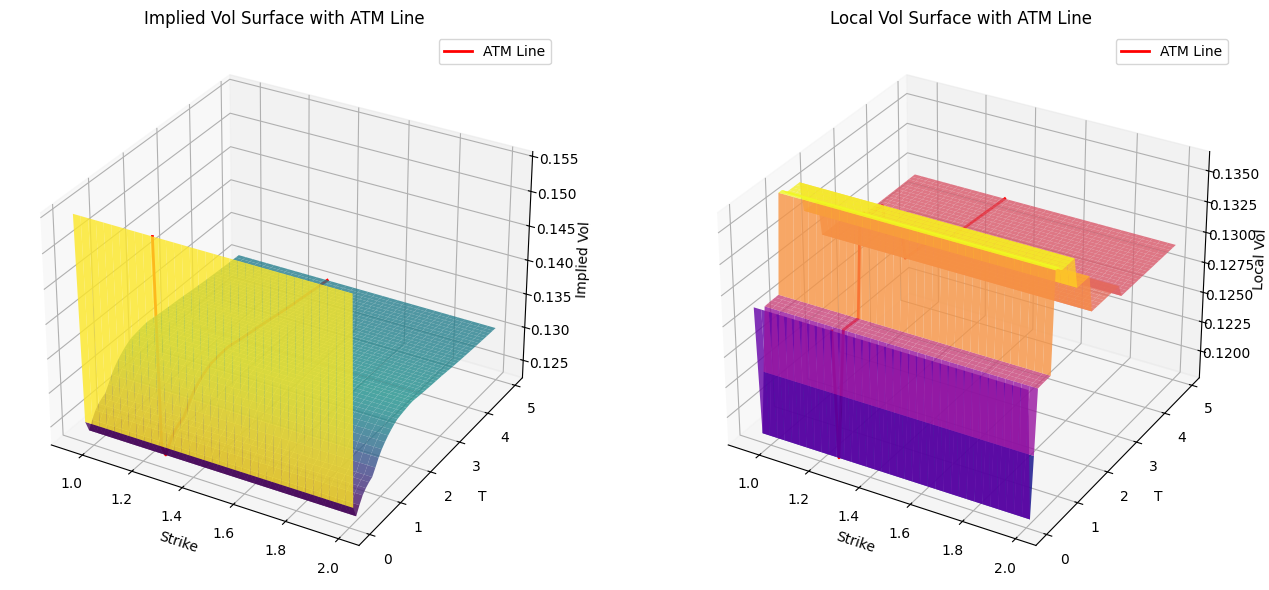

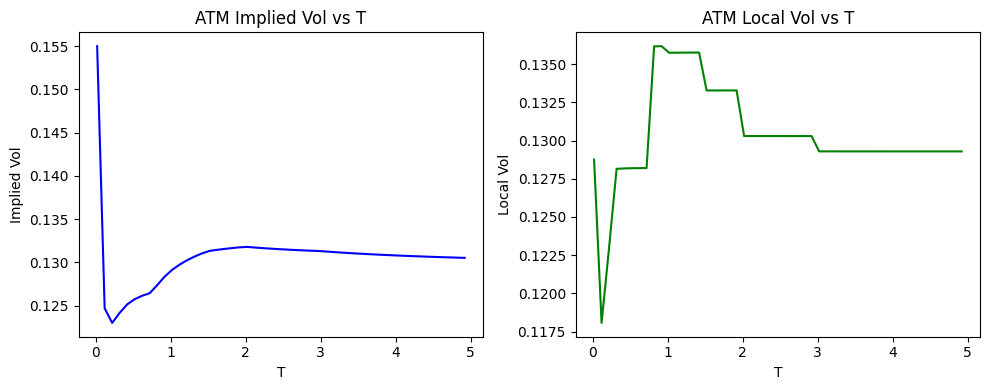

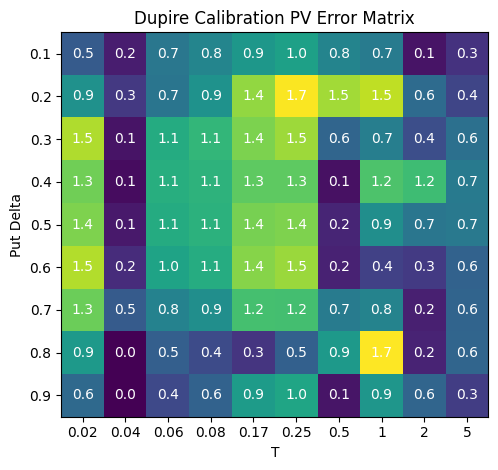

In [9]:
# ------------------------------
# Main Testing Section
# ------------------------------
S, r, q = 1.25805, 0.01, 0.0

iv = createTestImpliedVol(S, r, q, sc=0.0, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(S, r, q, iv)
pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a mild smile (tuned by the coeffiicent sc)

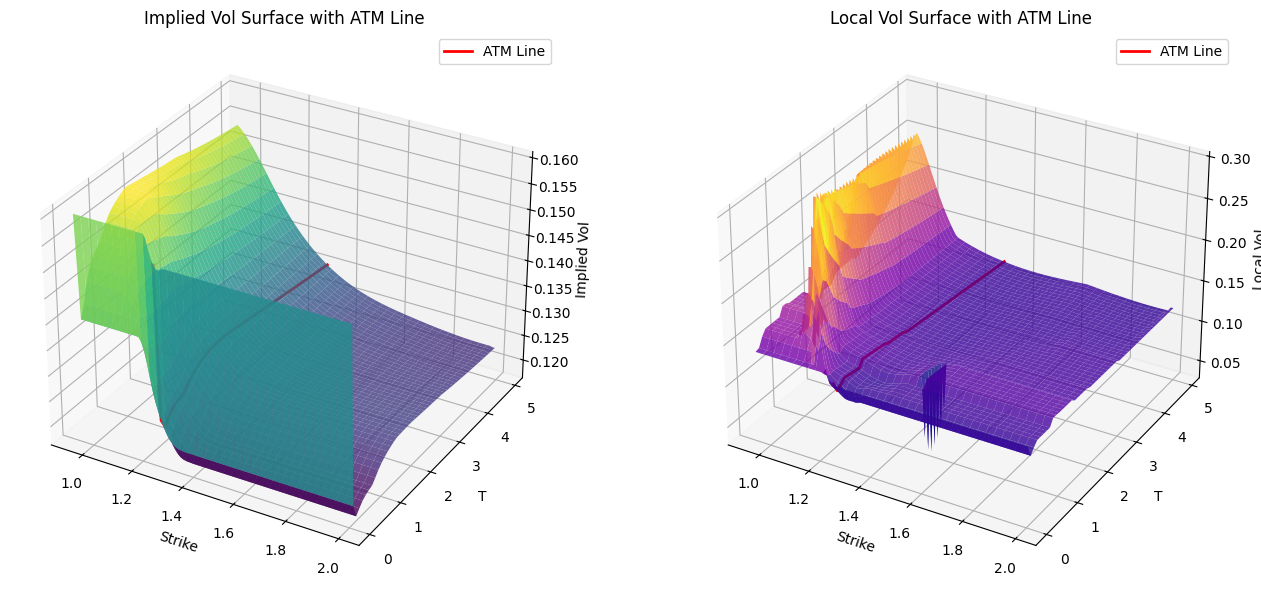

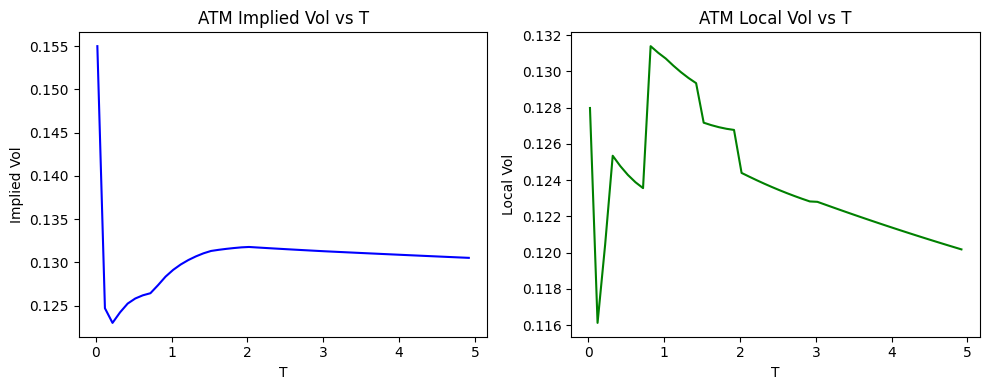

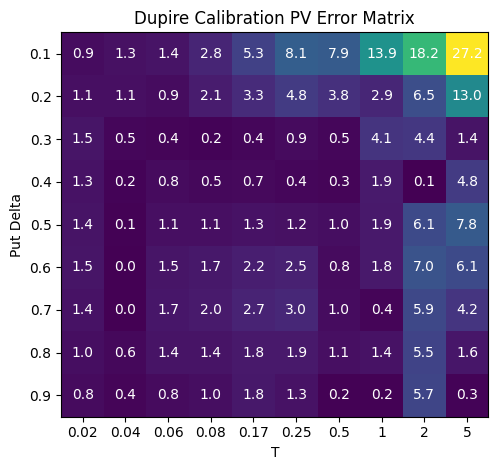

In [10]:
iv = createTestImpliedVol(S, r, q, sc = 0.5, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(S,r,q,iv)
pdeCalibReport(S, r, q, iv)


Then test smile case with CubicSpline, with a the input smile (sc = 1.0). It can be seen that the short end low strike region has some smile arbitrage. The calibration errors become larger.

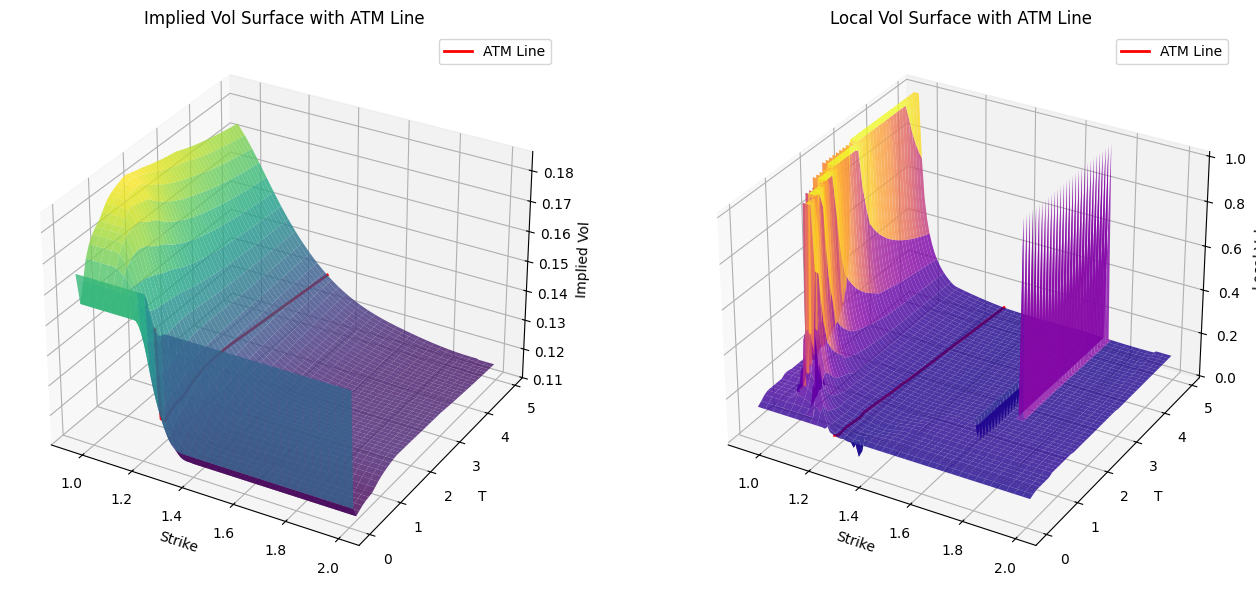

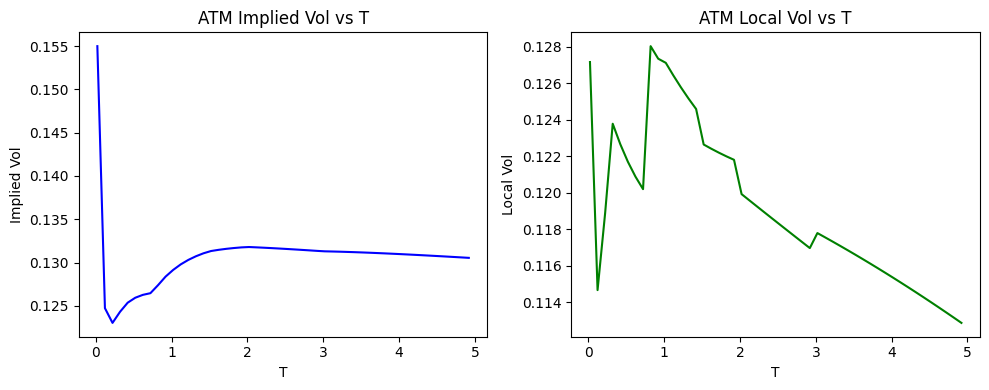

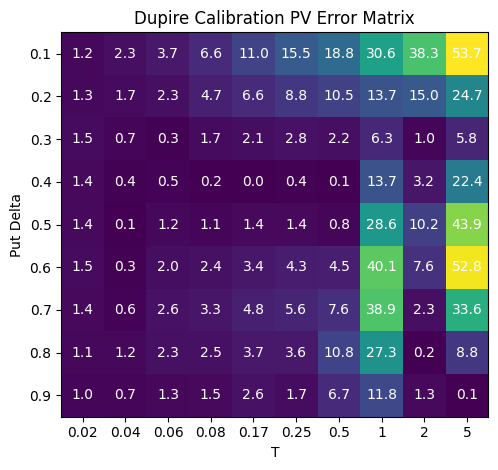

In [11]:
iv = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(S,r,q,iv)
pdeCalibReport(S, r, q, iv)


### Results
#### Your test cases with SmileAF

     pcost       dcost       gap    pres   dres
 0:  1.7985e+03  6.9799e+02  4e+03  2e+01  1e+02
     pcost       dcost       gap    pres   dres
 0:  6.7594e+02  1.9784e+02  2e+03  2e+01  8e+01
     pcost       dcost       gap    pres   dres
 0:  1.1129e+03  3.8895e+02  3e+03  2e+01  9e+01
 1:  1.8095e+03  1.5799e+03  6e+02  2e+00  1e+01
     pcost       dcost       gap    pres   dres
 0:  2.4159e+02  4.5385e+01  1e+03  1e+01  5e+01
     pcost       dcost       gap    pres   dres
 0:  3.6989e+02  8.1697e+01  1e+03  1e+01  6e+01
 1:  6.7821e+02  5.6486e+02  2e+02  2e+00  7e+00
 1:  1.1188e+03  9.5900e+02  4e+02  2e+00  1e+01
 2:  1.8280e+03  1.7972e+03  4e+01  8e-02  4e-01
     pcost       dcost       gap    pres   dres
 0:  2.2618e+01 -1.3309e+01  3e+02  1e+01  2e+01
 1:  2.4193e+02  1.8442e+02  1e+02  1e+00  4e+00
 1:  3.7073e+02  2.9405e+02  2e+02  1e+00  5e+00
 2:  6.8312e+02  6.6795e+02  2e+01  5e-02  2e-01
     pcost       dcost       gap    pres   dres
 0:  3.2036e+01 -1.4432e+01

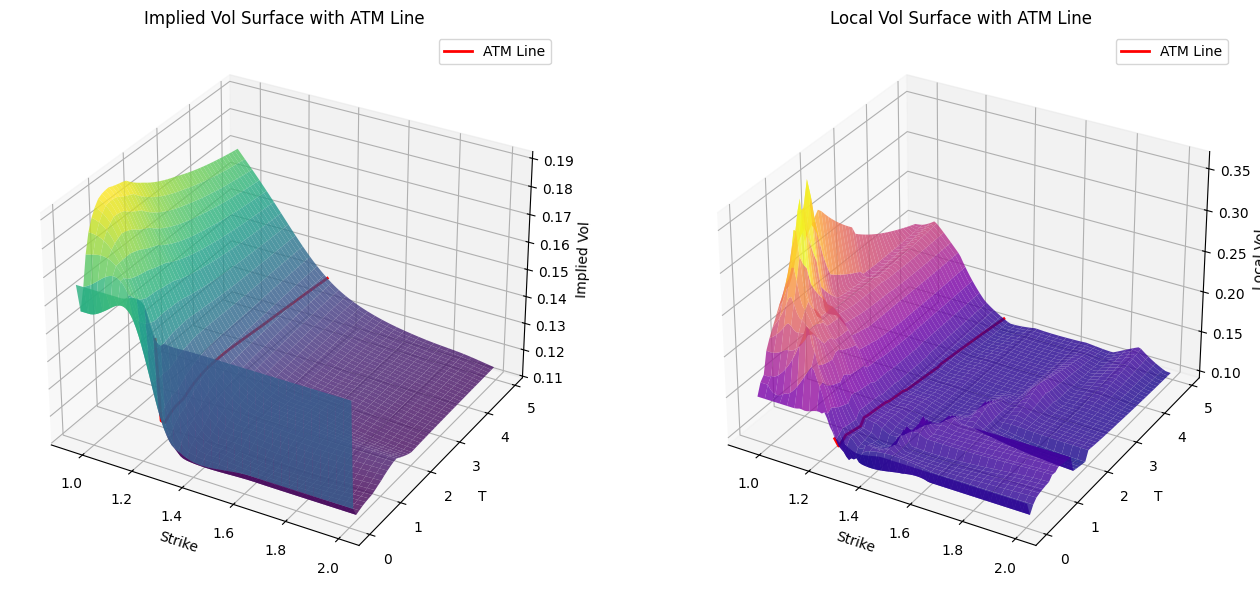

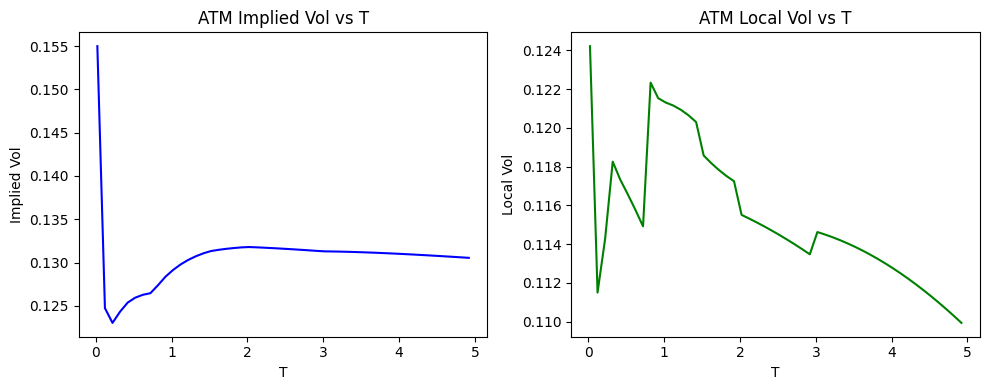

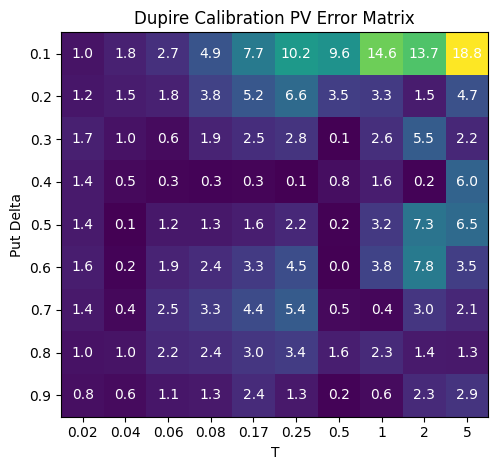

In [12]:
iv = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='AF')
plotTestImpliedVolSurface(S, r, q, iv) 
pdeCalibReport(S, r, q, iv)

### Conclusion

In this project, we successfully developed and implemented **SmileAF**, by enforcing **seven carefully designed constraints**, our model achieves theoretical soundness, numerical stability, and practical flexibility.

We made several optimizations to enhance performance, including improvements to key functions for faster computation.  
An additional soft constraint was introduced to further improve the model’s robustness, especially in controlling tail behavior.

The resulting **implied and local volatility surfaces** are smooth, stable, and arbitrage-free.  
We also improved the visualization components by adding **ATM lines** to both 3D plots, making the smile structure easier to interpret.  
In addition, a **2D plot of ATM volatility over time** was included to clearly show its term structure.

The **PDE-based pricing calibration** shows **consistently low errors** across different maturities and delta buckets, validating the robustness of our approach.  
The QP solver converged quickly in all cases, with negligible duality gaps and residuals.


### Improvements

- To further enhance the robustness and market applicability of the **SmileAF** framework, we propose some meaningful improvements:



##### Adaptive Penalty Tuning

- Currently, smoothing penalties in the optimization are fixed and applied uniformly across all market regimes. However, in practice, volatility smiles may vary in steepness or noisiness depending on market conditions. Introducing an adaptive tuning mechanism, which penalty weights are adjusted based on the shape or curvature of the smile, can help strike a better balance between smoothness and accuracy. This would allow the model to remain flexible and effective under both calm and volatile conditions.


##### Parametric Tail Extrapolation

- The current flat-tail assumption may result in unrealistic extrapolations, particularly for strikes far outside the observed market range.  To address this, we suggest replacing the flat tails with parametric functions such as exponential decay or power-law models. These functions offer more control over the slope and curvature at the extremes, leading to more stable density estimates and better pricing of deep in-the-money or out-of-the-money options.

##### Bid-Ask-Aware Calibration

- In real markets, quotes are usually given as a bid-ask range rather than a single price. Enforcing model prices to fall exactly on the mid-price can lead to overfitting, especially in illiquid markets. By incorporating inequality constraints that keep the model outputs within the bid-ask bounds, we can achieve more robust and realistic calibration. This not only improves consistency with real trading data but also enhances the model’s usefulness in production environments.
